# Notebook to load a trained model and verify it on some images

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import os
from data_process import *

In [2]:
#Architect of U_net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1,bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features = [64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Down part of U_net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #Up
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                    )# 28*1024 -> 56 * 512
            )
            self.ups.append(DoubleConv(feature*2, feature))
        #bottle
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)  #1024
        #final FF
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            #checking
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size= skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim = 1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

(1, 256, 256)


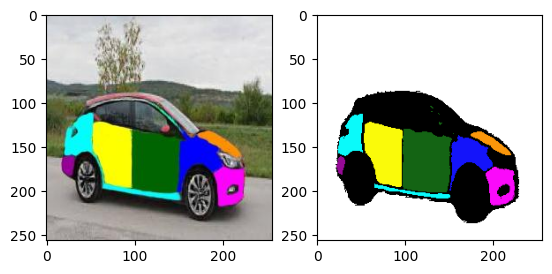

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load("../trained_models/unet_model_350_loss_trian_0.00411_val_0.00867.pt", map_location=device)
model.eval()
if __name__ =='__main__':
    path_to_seg_img = "../data/carseg_data/images/photo/with_segmentation/0029.jpg"
    path_to_no_seg_img = "../data/carseg_data/images/photo/no_segmentation/0029.jpg"
    reference = imread(path_to_seg_img)
    imgA = imread(path_to_no_seg_img)
    imgA = resize_2_256(imgA)

    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                         std=[0.229, 0.224, 0.225])])
    imgA = transform(imgA)
    imgA = imgA.to(device)
    imgA = imgA.unsqueeze(0)
    output = model(imgA)
    output = torch.sigmoid(output)

    output_np = output.cpu().detach().numpy().copy()  # output_np.shape = (1, 10, 256, 256)
    #print(output_np.shape)   #(1, 10, 256, 256)
    output_np = (np.argmax(output_np, axis=1) * 10).astype(np.uint8)
    print(output_np.shape)  #(1,256, 256)
    #print(output_np[0,...])
    plt.subplot(1, 2, 1)
    plt.imshow(reference)
    plt.subplot(1, 2, 2)
    plt.imshow(label_2_colour(output_np[0, ...]))
